In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
## 언어모델 및 tokenizer 불러오기
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# GPU 작동 확인
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


In [ ]:
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
DATASET_NAME = "finance_data.csv"

In [ ]:
urllib.request.urlretrieve(DATASET_URL,
                           filename = DATASET_NAME
                           )

('finance_data.csv', <http.client.HTTPMessage at 0x7f1a0c07cdf0>)

In [ ]:
dataset = pd.read_csv(DATASET_NAME)
dataset.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


**데이터 전처리**

In [ ]:
del dataset['sentence']

In [ ]:
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
dataset.head()  # 중립 0, 긍정 1 , 부정 2

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [ ]:
# 중복데이터 확인
dataset[dataset['kor_sentence'].duplicated()]

,labels,kor_sentence
79,1,텔레콤월드와이어-2006년 4월 7일-TJ 그룹은 모닝 디지털 디자인 Oy 핀란드 ...
789,0,그룹의 사업은 스포츠의 광범위한 포트폴리오와 모든 주요 시장에서의 입지에 의해 균형...
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.


In [ ]:
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True)

Text(0, 0.5, 'Number')

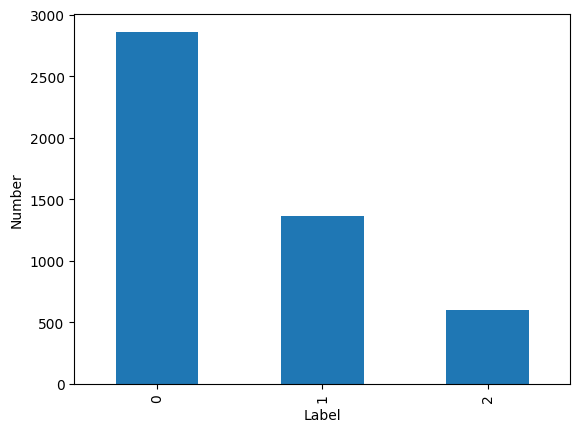

In [ ]:
# 라벨별 데이터 분포 확인
dataset['labels'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

In [ ]:
dataset['labels'].value_counts(normalize = True)

0    0.592708
1    0.282163
2    0.125129
Name: labels, dtype: float64

In [ ]:
# Test / Train 데이터 분리

# 입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

In [ ]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [ ]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 3861
테스트 입력 데이터 개수: 966


In [ ]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

0    0.592852
1    0.282051
2    0.125097
Name: labels, dtype: float64

In [ ]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

0    0.592133
1    0.282609
2    0.125259
Name: labels, dtype: float64

In [ ]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

BERT 입력용 데이터 포맷으로 변경

In [ ]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets


In [ ]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

3861it [00:02, 1570.87it/s]


In [ ]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

966it [00:00, 1560.28it/s]


BERT 기반 감정 분류 모델링

In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [ ]:
# BERT 출력 정의
bert_output = bert_outputs[0]

In [ ]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [ ]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [ ]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model_03.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

In [ ]:
EPOCHS = 50
BATCH_SZIE = 32

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 1.2926 - accuracy: 0.2108
Epoch 1: val_loss improved from inf to 1.20800, saving model to ./model/best_model_03.h5
121/121 [==============================] - 105s 583ms/step - loss: 1.2926 - accuracy: 0.2108 - val_loss: 1.2080 - val_accuracy: 0.2371
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 1.1295 - accuracy: 0.2372
Epoch 2: val_loss improved from 1.20800 to 0.88618, saving model to ./model/best_model_03.h5
121/121 [==============================] - 99s 823ms/step - loss: 1.1295 - accuracy: 0.2372 - val_loss: 0.8862 - val_accuracy: 0.8043
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6459
Epoch 3: val_loss improved from 0.88618 to 0.76188, saving model to ./model/best_model_03.h5
121/121 [==============================] - 103s 851ms/step - loss: 0.7403 - accuracy: 0.6459 - val_loss: 0.7619 - val_accuracy: 0.8395
Epoch 4/50
121/121 [=============

# 모델 테스트

In [ ]:
# best_model.h5 - drop_out : 0.5
BEST_MODEL_NAME = './model/best_model.h5'
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME, custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})
sentiment_model_best.evaluate(test_x, test_y, batch_size=1024)

1/1 [==============================] - 7s 7s/step - loss: 0.5228 - accuracy: 0.8582


[0.5228097438812256, 0.8581780791282654]